# Connecting

In [1]:
import os

# setting working dir
os.chdir("../src")

In [2]:
from elasticsearch_db.elasticsearch import elastic_conection
from elasticsearch_db.elasticsearch import get_nlp_model

es = elastic_conection()

In [3]:
workspace_id = "dc1e7b3d-9137-4a20-a99c-d0d2029ef170"
workspace, exist = get_nlp_model(es, workspace_id=workspace_id)
exist

True

# Data Sourcing

In [4]:
from data_pipeline.data_sourcing import get_data

get_data?

Signature: get_data(workspace, es)
Docstring:
Get all the intents in the elasticsearch
workspace's index.

Parameters
----------
workspace: the workspace object
es: the elasticsearch conection instance

Returns
-------
list: a list of namedtuple Intents
    
Examples
--------

Raises
------

Notes
-----
File:      /usr/omni_nlu_api/src/data_pipeline/data_sourcing.py
Type:      function


In [5]:
data = get_data(workspace=workspace, es=es)
print(len(data))
print(data[0])

206
Intent(intent_name='Inativar_Posição', examples_text=['Como realizo a inativação de uma posição de minha estrutura?', 'Como realizo a reativação de uma posição em minha estrutura?', 'Em quanto tempo a inativação de uma posição é efetivada?', 'Gostaria de fazer a inativação de uma posição, como faço?', 'Realizei a inativação de uma posição e ela continua visível?'])


# Data Preprocessing

### Create artificial Examples

In [6]:
from data_pipeline.data_preprocessing import fill_missing_examples

fill_missing_examples?

Signature: fill_missing_examples(data, random_seed=42)
Docstring:
We expect at least 8 examples for each intent,
5 to train and 3 to test the ML models.

This function identify intents with less then 8 examples
and fill it up with artificial examples created from the 
exesting ones.

Parameters
----------
data: list of namedtuple representing Intents

Returns
-------
list: list of namedtuple representing Intents
    
Examples
--------
input = [
    Intent(
        intent_name='Inativar_Posição', 
        examples_text=['Como realizo a inativação de uma posição de minha estrutura?', 
                       'Como realizo a reativação de uma posição em minha estrutura?', 
                       'Em quanto tempo a inativação de uma posição é efetivada?', 
                       'Gostaria de fazer a inativação de uma posição, como faço?', 
                       'Realizei a inativação de uma posição e ela continua visível?']
        )
]

output = [
    Intent(
        intent_name='Inativar_

In [7]:
data = fill_missing_examples(data)

### Cleansing

In [8]:
from data_pipeline.data_preprocessing import clean_examples

clean_examples?

Signature: clean_examples(data)
Docstring:
Clean examples.

Parameters
----------
data: list of namedtuple representing Intents

Returns
-------
list: a list of namedtuple Examples.
    
Examples
--------

Please, see the TheDataFlow.ipynb notebook 
in the jupyter_notebook directory. Look for
Data Preprocessing topic and Cleansing sub-topic.

Raises
------

Notes
-----
File:      /usr/omni_nlu_api/src/data_pipeline/data_preprocessing.py
Type:      function


In [9]:
data = clean_examples(data)

In [10]:
data[0]

Intent(intent_name='Inativar_Posição', examples_text=['realiz inativ pos estrut', 'realiz reativ pos estrut', 'quant temp inativ pos efetiv', 'gost faz inativ pos fac', 'realiz inativ pos continu vis', 'realiz inativ um pos estrutur', 'realiz inativ um pos continu vis', 'quantum temp inativ um pos efetiv'])

# Data Splitting

In [11]:
from data_pipeline.data_splitting import data_splitting

data_splitting?

Signature: data_splitting(data, test_ratio=0.3, random_seed=42)
Docstring:
The split between train, valid and test sets occurs at the 
intent level. We want to assure that all intents 
are represented in boths sets.

Parameters
----------
data: list of namedtuple representing Intents

test_ratio: a float, between 0.0 and 1.0, that tells the
percentage of examples to chose from a intent if it has eight 
or more examples.

random_seed: the random seed.

Returns
-------
list: a list of namedtuple Examples.
    
Examples
--------

Please, see the TheDataFlow.ipynb notebook 
in the jupyter_notebook directory. Look for
Data Splitting topic.

Raises
------

Notes
-----
File:      /usr/omni_nlu_api/src/data_pipeline/data_splitting.py
Type:      function


In [12]:
train, test = data_splitting(data)

In [13]:
train.tail()

,intent_name,example_text
1091,Vizinho_Invadindo_Terreno,est problem vi unidad poss fal
1092,Vizinho_Invadindo_Terreno,vi unidad invad part imovel yar faz
1093,Vizinho_Invadindo_Terreno,terren est invad pel vizinh unidad faz
1094,Vizinho_Invadindo_Terreno,unidad est invad pod ajud
1095,Vizinho_Invadindo_Terreno,vizinh unidad est invad um part imovel yar faz


In [14]:
test.tail()

,intent_name,example_text
552,Visao_Geral_Previdencia_Privada,pod fal sobr previd priv
553,Visao_Geral_Previdencia_Privada,com funcion plan previd priv
554,Vizinho_Invadindo_Terreno,unidad send invad pod ajud
555,Vizinho_Invadindo_Terreno,terren send invad vi unidad faz
556,Vizinho_Invadindo_Terreno,est problem vi unidad pod fal


# Scikit Learn Pipe Line

In [30]:
# from sklearn.compose import make_column_transformer
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

In [22]:
# transformer = LabelBinarizer()
transformer = LabelEncoder()
y_train = np.ravel(transformer.fit_transform(train.intent_name))
y_train

array([111, 111, 111, ..., 205, 205, 205])

In [67]:
transformer.inverse_transform([111, 100, 205, 0, 1])

array(['Inativar_Posição', 'Fazer_Contrato', 'Vizinho_Invadindo_Terreno',
       'Abono', 'Abrir_Chamado_Salario'], dtype=object)

In [53]:
hyper_parameters = {
          "C": 5,
          "fit_intercept": False,
          "random_state": 1,
          "max_iter": 1000
        }

logreg = LogisticRegression(
                    multi_class="multinomial",
                    n_jobs=-1,
                    **hyper_parameters
        )
        

model = Pipeline(
            steps= [
                ('text_features', TfidfVectorizer()),
                ('model', logreg)
            ]
        )

In [42]:
X_train = text_features.fit_transform(train.example_text)

In [54]:
cross_val_score(model, train.example_text, y_train, cv=5, scoring='accuracy').mean()

/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


0.6688293897882939

In [55]:
model.fit(train.example_text, y_train)

Pipeline(steps=[('text_features', TfidfVectorizer()),
                ('model',
                 LogisticRegression(C=5, fit_intercept=False, max_iter=1000,
                                    multi_class='multinomial', n_jobs=-1,
                                    random_state=1))])

In [56]:
model.classes_

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [26]:
X_test = text_features.fit_transform(train.example_text)

In [61]:
[train.example_text[0]]

['quant temp inativ pos efetiv']

In [60]:
model.predict_proba([train.example_text[0]])

array([[0.00161367, 0.00162917, 0.00153952, 0.00161252, 0.00160862,
        0.00162839, 0.00161768, 0.00776304, 0.00161973, 0.00159184,
        0.00161182, 0.00155349, 0.00161711, 0.00163906, 0.00157892,
        0.0016162 , 0.00162226, 0.00163381, 0.00162664, 0.00155312,
        0.00152386, 0.00160225, 0.00161829, 0.00160845, 0.00161433,
        0.00160944, 0.00323867, 0.00160048, 0.00162622, 0.00161679,
        0.00845913, 0.00544037, 0.00164158, 0.00163864, 0.00162907,
        0.00158999, 0.00159081, 0.00160694, 0.00155991, 0.00160983,
        0.00164227, 0.00163695, 0.00161367, 0.00160783, 0.00160283,
        0.00163553, 0.00163   , 0.00163305, 0.00162953, 0.00162846,
        0.00148005, 0.00162406, 0.00161066, 0.00159372, 0.00163411,
        0.00159805, 0.00162368, 0.00163461, 0.00162646, 0.00163889,
        0.00157984, 0.00157542, 0.00162571, 0.00162885, 0.00156692,
        0.01178298, 0.00164173, 0.00163307, 0.00156552, 0.001621  ,
        0.0016254 , 0.00163418, 0.00162608, 0.00

# Training

#### Logistic Regression

In [76]:
from sklearn.linear_model import LogisticRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import numpy as np


def train_logreg(X, y, **hyper_parameters):
    logreg = LogisticRegression(
                    multi_class="multinomial",
                    n_jobs=-1,
                    **hyper_parameters
        )
        
    model = Pipeline(
                steps= [
                    ('text_features', TfidfVectorizer()),
                    ('model', logreg)
                ]
            )
#     regr = TransformedTargetRegressor(regressor=model,
#                                    transformer=LabelEncoder())
    model.fit(X, y)
    return model

In [91]:
hyper_parameters = {
          "C": 5,
          "fit_intercept": False,
          "random_state": 1,
          "max_iter": 1000
        }

logreg_clf = train_logreg(
                    X=train.example_text, 
                    y=train.intent_name,
                    **hyper_parameters
            )

In [92]:
y_pred = logreg_clf.predict(test.example_text)
np.sum((y_pred == test.intent_name)) / test.shape[0]

0.6876122082585279

#### SVM

In [94]:
from sklearn import svm

def train_svm(X, y, **hyper_parameters):
    poly_svm = svm.SVC(
                    kernel="poly", 
                    probability=True,
                    **hyper_parameters
              )
        
    model = Pipeline(
                steps= [
                    ('text_features', TfidfVectorizer()),
                    ('model', poly_svm)
                ]
            )
    model.fit(X, y)
    return model

In [96]:
hyper_parameters = {
          "degree": 1,
          "coef0": 0,
          "random_state": 42
        }
svm_clf = train_svm(
                X=train.example_text, 
                y=train.intent_name,
                **hyper_parameters
            )

In [97]:
y_pred = svm_clf.predict(test.example_text)
np.sum((y_pred == test.intent_name)) / test.shape[0]

0.6624775583482945

In [106]:
svm_clf.named_steps["text_features"].get_feature_names()[100:120]

['ant',
 'anteri',
 'antig',
 'aond',
 'aparec',
 'aparelh',
 'apen',
 'aplic',
 'apos',
 'app',
 'apres',
 'apresent',
 'aprov',
 'aproveit',
 'apur',
 'aqu',
 'are',
 'arquiv',
 'asat',
 'assalt']

In [101]:
train.intent_name.nunique()

206

#### Neural Network

In [212]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder

class MyOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self, y):
        return self
    
    def transform(self, y):
        self.transformer = OneHotEncoder(sparse=False)
        y_ohe = self.transformer.fit_transform(y)
        return y_ohe
    
    def inverse_transform(self, predict_y):
        y = self.transformer.inverse_transform(predict_y)
        return y

In [213]:
trans = MyOneHotEncoder()

In [215]:
trans.fit(test.intent_name.to_numpy().reshape(-1, 1))

MyOneHotEncoder()

In [216]:
result = trans.transform(test.intent_name.to_numpy().reshape(-1, 1))

In [217]:
result[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

In [218]:
trans.inverse_transform([result[0]])

array([['Inativar_Posição']], dtype=object)

In [219]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder

global learning_rate; learning_rate = 0.001
global loss; loss = "categorical_crossentropy"
global number_of_intent_classes 
number_of_intent_classes = train.intent_name.nunique()
n_features = svm_clf.named_steps["text_features"].get_feature_names()
global input_shape; input_shape = (n_features,)

# Keras Model
def build_nn(**hyper_parameters):
    model = Sequential()
    model.add(
            Dense(
                units=input_shape[0],
                activation="relu",
                input_shape=input_shape,
                name="input_layer",
            )
    )
    model.add(Dense(units=input_shape[0], activation="relu", name="layer_2"))
    # Output
    model.add(
        Dense(units=number_of_intent_classes, activation="softmax", name="output_layer")
    )

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=loss,
        metrics=["accuracy"],
        epochs=100,
        verbose=False,
        batch_size=100
    )
    return model

def to_onehot(y):
    global transformer
    transformer = OneHotEncoder(sparse=False)
    return transformer.fit_transform(y)

def back_to_intent_name(y):
    return transformer.reverse_transform(y)

def train_nn(X, y, **hyper_parameters):
    nn = KerasClassifier(build_nn)
    nn._estimator_type = "classifier"
    model = Pipeline(
                steps= [
                    ('text_features', TfidfVectorizer()),
                    ('model', nn)
                ]
            )
    regres = TransformedTargetRegressor(
                                regressor=model,
                                transformer=MyOneHotEncoder()
            )
    regres.fit(X, y);
    return regres

In [220]:
# hyper_parameters = {
#   "epochs": 100,
#   "verbose":False,
#   "batch_size": 100,
#   "validation_data":(test.example_text, 
#                      test.intent_name)
# }

nn_clf = train_nn(
                X=train.example_text, 
                y=test.intent_name.to_numpy().reshape(-1, 1)
          )

ValueError: could not convert string to float: 'Inativar_Posição'

# Feature Encoding

### Intents Onehot map

In [16]:
from data_pipeline.feature_engineering import intents_to_onehot

intents_to_onehot?

Signature: intents_to_onehot(intents_name)
Docstring: <no docstring>
File:      /usr/omni_nlu_api/src/data_pipeline/feature_engineering.py
Type:      function


In [17]:
??intents_to_onehot

Signature: intents_to_onehot(intents_name)
Docstring: <no docstring>
Source:   
def intents_to_onehot(intents_name):
    array_intents_name = np.asarray([[intent_name] for intent_name in intents_name])
    encoder = OneHotEncoder(sparse=False)
    onehot_intents = encoder.fit_transform(array_intents_name) 
    map_onehot = {
        intent: onehot
        for intent, onehot in zip(intents_name, onehot_intents)
    }
    # use to identify the intent name 
    # in the prediction fase
    intent_dictionary = {
        str(np.argmax(value)): key
        for key, value in zip(map_onehot.keys(), map_onehot.values())
    }
    return map_onehot, intent_dictionary
File:      /usr/omni_nlu_api/src/data_pipeline/feature_engineering.py
Type:      function


In [18]:
intents_name = set([intent[0] for intent in data])

In [19]:
map_onehot, intent_dictionary = intents_to_onehot(intents_name=intents_name)

### TF-IDF corpus

In [20]:
from data_pipeline.feature_engineering import create_corpus

create_corpus?

Signature: create_corpus(examples_text)
Docstring: <no docstring>
File:      /usr/omni_nlu_api/src/data_pipeline/feature_engineering.py
Type:      function


In [21]:
??create_corpus

Signature: create_corpus(examples_text)
Docstring: <no docstring>
Source:   
def create_corpus(examples_text):
    vectorizer = TfidfVectorizer()
    corpus = vectorizer.fit(examples_text)
    return corpus
File:      /usr/omni_nlu_api/src/data_pipeline/feature_engineering.py
Type:      function


In [22]:
examples_text = [example[1] for example in train] + [example[1] for example in test]
corpus = create_corpus(examples_text=examples_text)

### Examples as TF-IDF vectors

In [23]:
from data_pipeline.feature_engineering import encode_features

encode_features?

Signature: encode_features(train, test, corpus, map_onehot)
Docstring: <no docstring>
File:      /usr/omni_nlu_api/src/data_pipeline/feature_engineering.py
Type:      function


In [24]:
??encode_features

Signature: encode_features(train, test, corpus, map_onehot)
Docstring: <no docstring>
Source:   
def encode_features(train, test, corpus, map_onehot):
    
    y_train = np.stack([map_onehot[example[0]] for example in train])
    X_train = corpus.transform([example[1] for example in train]).toarray()
    
    y_test = np.stack([map_onehot[example[0]] for example in test])
    X_test = corpus.transform([example[1] for example in test]).toarray()
    
    return X_train, y_train, X_test, y_test
File:      /usr/omni_nlu_api/src/data_pipeline/feature_engineering.py
Type:      function


In [25]:
X_train, y_train, X_test, y_test = encode_features(
                                            train=train, 
                                            test=test, 
                                            corpus=corpus, 
                                            map_onehot=map_onehot
                                    )

In [26]:
X_train.shape

(1096, 1258)

In [27]:
y_train.shape

(1096, 206)

In [28]:
X_test.shape

(557, 1258)

In [29]:
y_test.shape

(557, 206)

# Train ensemble

In [33]:
from sklearn.base import BaseEstimator, TransformerMixin

class IndexLabelEncode(BaseEstimator, TransformerMixin):
    def __init__(self, y, is_nn=False, **kwargs):
        self.is_nn = is_nn
        self.y = y
        self.shape = y[-1].shape
    
    def fit(self, y):
        
        return self
    
    def transform(self, y):
        if not self.is_nn:
            y_ = [np.argmax(onehot) for onehot in y]
            return np.array(y_)
        return y
    
    def inverse_transform(self, predict_y):
        if not self.is_nn:
            y_ = []
            for result in predict_y:
                prediction = np.zeros(self.shape)
                prediction[int(result)] = 1
                y_.append(prediction)
            return np.stack(y_)
        return predict_y

#### Logit

In [76]:
X_train2 = np.array([item[1] for item in train])
y_train2 = np.array([item[0] for item in train])
X_test2 = np.array([item[1] for item in test])
y_test2 = np.array([item[0] for item in test])

In [82]:
from sklearn.base import TransformerMixin #gives fit_transform method for free
class MyLabelBinarizer(TransformerMixin):
    def __init__(self, *args, **kwargs):
        self.encoder = LabelBinarizer(*args, **kwargs)
    def fit(self, x, y=0):
        self.encoder.fit(x)
        return self
    def transform(self, x, y=0):
        return self.encoder.transform(x)

In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import LabelBinarizer
from sklearn.pipeline import make_pipeline
import numpy as np
import json

hyper_parameters = {
          "C": 5,
          "fit_intercept": False,
          "random_state": 1,
          "max_iter": 1000
        }


def train_LogisticRegression(X, y,  **hyper_parameters):
    encode_feature = Pipeline(
                        steps=[
                            ('vect', CountVectorizer()),
                            ('encoding_features', TfidfTransformer()),
                         ]
                     )
    
    intents_to_onehot
    
    logreg = LogisticRegression(
                        multi_class="multinomial",
                        n_jobs=-1,
                        **hyper_parameters
             )
    pipe = make_pipeline(encode_feature, intents_to_onehot, logreg)
    pipe.fit(X, y);
    return pipe

logit_clf = train_LogisticRegression(
                            X=X_train2,
                            y=y_train2,
                            **hyper_parameters
            )

# y_pred = logit_clf.predict(X_test2)
# accuracy = np.sum((y_pred == y_test2).all(1)) / y_test.shape[0]
# accuracy
# logit_clf.get_params()

TypeError: len() of unsized object

#### SVM

In [159]:
from sklearn import svm
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

hyper_parameters = {
          "degree": 1,
          "coef0": 0,
          "random_state": 42
        }
def train_SVM(X, y, **hyper_parameters):
    
    model = TransformedTargetRegressor(
                                regressor=svm.SVC(kernel="poly", 
                                                probability=True,
                                                **hyper_parameters
                                          ),
                                transformer=IndexLabelEncode(y=y)
            )
    
    model.fit(X, y);
    return model

svm_clf = train_SVM(
                X=X_train,
                y=y_train,
                **hyper_parameters
         )
y_pred = svm_clf.predict(X_test)
accuracy = np.sum((y_pred == y_test).all(1)) / y_test.shape[0]
accuracy

0.6427289048473968

In [190]:
svm_clf.predict_proba(y_test[0])

AttributeError: 'TransformedTargetRegressor' object has no attribute 'predict_proba'

#### Artificial Neural NetWork

In [160]:
import matplotlib.pyplot as plt

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [177]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

global learning_rate; learning_rate = 0.001
global loss; loss = "categorical_crossentropy"
global number_of_intent_classes 
number_of_intent_classes = y_train.shape[1]
global input_shape; input_shape = (X_train.shape[1],)

# Keras Model
def build_nn():
    model = Sequential()
    model.add(
            Dense(
                units=input_shape[0],
                activation="relu",
                input_shape=input_shape,
                name="input_layer",
            )
    )
    model.add(Dense(units=input_shape[0], activation="relu", name="layer_2"))
    # Output
    model.add(
        Dense(units=number_of_intent_classes, activation="softmax", name="output_layer")
    )

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=loss,
        metrics=["accuracy"],
    )
    return model

In [184]:
def train_nn(X, y, **hyper_parameters):
    model = KerasClassifier(build_nn)
    model._estimator_type = "classifier"
    history = model.fit(X, y, **hyper_parameters);
    return model, history

In [185]:
hyper_parameters = {
  "epochs": 100,
  "verbose":False,
  "batch_size": 100,
  "validation_data":(X_test, y_test)
}

keras_clf, history = train_nn(
                X=X_train,
                y=y_train,
                **hyper_parameters
         )

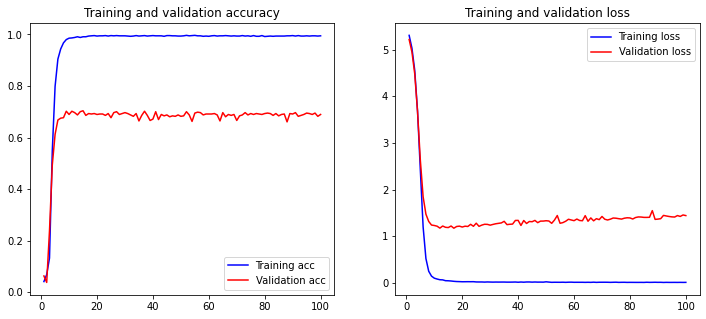

In [186]:
plot_history(history)

In [187]:
val_acc = history.history['val_accuracy']
val_acc[-1]

0.6894075274467468

#### Voting

In [188]:
from sklearn.ensemble import VotingClassifier

def train_voting(X_train, y_train, estimators, weights, **kwargs):
    meta_model = VotingClassifier(
                        estimators=estimators,
                        weights=weights,
                        **kwargs)
#     model = TransformedTargetRegressor(
#                                 regressor=meta_model,
#                                 transformer=IndexLabelEncode(y=y)
#             )
    meta_model.fit(X_train, y_train)
    return meta_model


estimators = [('clf1', logit_clf), 
              ('clf2', svm_clf),
              ('clf3', keras_clf)]
weights = [0.6929982046678635, 0.6427289048473968, 0.6894075274467468]
voting = train_voting(X_train, y_train, 
                      estimators, 
                      weights,
                      voting='soft',
                      flatten_transform=True,
                      n_jobs=-1)
y_pred = voting.predict(X_test)
accuracy = np.sum((y_pred == y_test).all(1)) / y_test.shape[0]
accuracy

NotImplementedError: Multilabel and multi-output classification is not supported.

# Prefect

In [1]:
import os

# setting working dir
os.chdir("../src")

from prefect import Flow, task, context

from data_pipeline.data_sourcing import get_data
from data_pipeline.data_preprocessing import fill_missing_examples, clean_examples
from data_pipeline.feature_engineering import intents_to_onehot, create_corpus, encode_features
from data_pipeline.data_splitting import data_splitting
from elasticsearch_db.elasticsearch import elastic_conection
from elasticsearch_db.elasticsearch import get_nlp_model

es = elastic_conection()
workspace_id = "dc1e7b3d-9137-4a20-a99c-d0d2029ef170"
workspace, exist = get_nlp_model(es, workspace_id=workspace_id)
exist

True

In [2]:
@task
def sourcing(workspace, es):

    return get_data(
                workspace=workspace, 
                es=es
            )

@task
def imputation(data):
    
    return fill_missing_examples(data)

@task
def cleansing(data):

    return clean_examples(data)

@task(nout=2)
def splitting(data):

    return data_splitting(data)

@task(nout=4)
def encoding(train, test):
    all_intents = set([example[0] for example in train])
    map_onehot, intent_dictionary = intents_to_onehot(
                                        intents_name=all_intents
                                    )
    all_examples = [example[0] for example in train] + \
                   [example[0] for example in test]
        
    corpus = create_corpus(examples_text=all_examples)
    
    X_train, y_train, X_test, y_test = encode_features(
                                            train=train, 
                                            test=test, 
                                            corpus=corpus, 
                                            map_onehot=map_onehot
                                    )
    return X_train, y_train, X_test, y_test

In [3]:
# Define prefect flow
with Flow("train_dataflow") as flow:

    data = sourcing(workspace=workspace, es=es)
    data = imputation(data=data)
    data = cleansing(data=data)
    train, test = splitting(data=data)
    X_train, y_train, X_test, y_test = encoding(train=train, 
                                                test=test)

[2021-04-21 12:08:00+0000] INFO - prefect.FlowRunner | Beginning Flow run for 'train_dataflow'
[2021-04-21 12:08:01+0000] INFO - prefect.TaskRunner | Task 'sourcing': Starting task run...
[2021-04-21 12:08:01+0000] INFO - prefect.TaskRunner | Task 'sourcing': Finished task run for task with final state: 'Success'
[2021-04-21 12:08:01+0000] INFO - prefect.TaskRunner | Task 'imputation': Starting task run...
[2021-04-21 12:08:21+0000] INFO - prefect.TaskRunner | Task 'imputation': Finished task run for task with final state: 'Success'
[2021-04-21 12:08:21+0000] INFO - prefect.TaskRunner | Task 'cleansing': Starting task run...
[2021-04-21 12:08:22+0000] INFO - prefect.TaskRunner | Task 'cleansing': Finished task run for task with final state: 'Success'
[2021-04-21 12:08:22+0000] INFO - prefect.TaskRunner | Task 'splitting': Starting task run...
[2021-04-21 12:08:22+0000] INFO - prefect.TaskRunner | Task 'splitting': Finished task run for task with final state: 'Success'
[2021-04-21 12:08

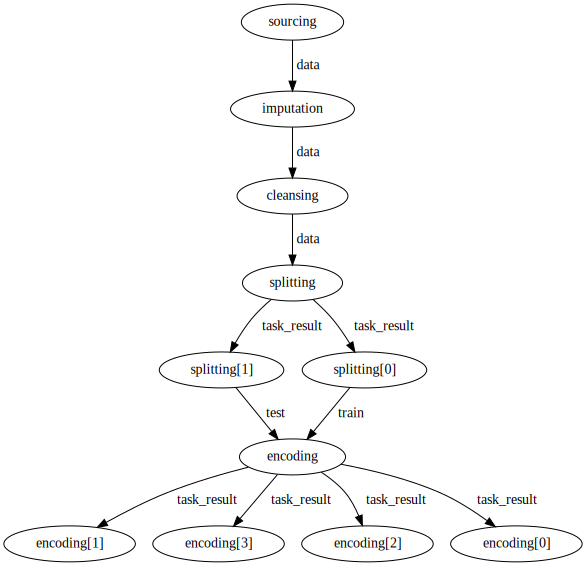

In [4]:
# Run prefect flow
flow.run()

# Export flow as a PDF
flow.visualize(filename="../src/data_pipeline/flow_diagrams/train_dataflow")